In [34]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler, SMOTE
import glob
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score


In [2]:
folder_path="C:/Users/bless/OneDrive/MS_Studies/AML/proteomics/Class_L_L/L_L_FEATURES/"
files = os.listdir(folder_path)

file_path=[]
csvfiles=[]
# Iterate through each file
for file in files:
    # Create the absolute path of the file
    file_path.append(os.path.join(folder_path, file))
#print(file_path[1])

for i in file_path:
    csvfiles.append(pd.read_csv(i))
print(csvfiles)

# fig, ax = plt.subplots(figsize=(5, 5))
# ax.scatter(csvfiles[5][['RT']],csvfiles[5][['mz']],s=2)
# plt.show()
#print(csvfiles[0][['RT','mz']])
#     # Check if the path is a file (not a directory)
# for i in range(len(file_path)):
#     if os.path.isfile(i):
#         # Read the file contents
#         with open(i, 'r') as f:
#             contents = f.read()
#             # Process the file contents as desired
#             print(contents)

[                 feature_id peptide_sequence  peptide_score ID_filename  \
0       7824516127477318561             None            NaN        None   
1       2833402173127023518             None            NaN        None   
2       3584105666006860450             None            NaN        None   
3       3236426940903996542             None            NaN        None   
4      13968718414037055507             None            NaN        None   
...                     ...              ...            ...         ...   
48359  17692242579154914811             None            NaN        None   
48360  14245534933568202430             None            NaN        None   
48361  15217590542929036366             None            NaN        None   
48362  13159352137877410242             None            NaN        None   
48363   6790395557460457612             None            NaN        None   

      ID_native_id  charge           RT          mz  RTstart    RTend  \
0             None       

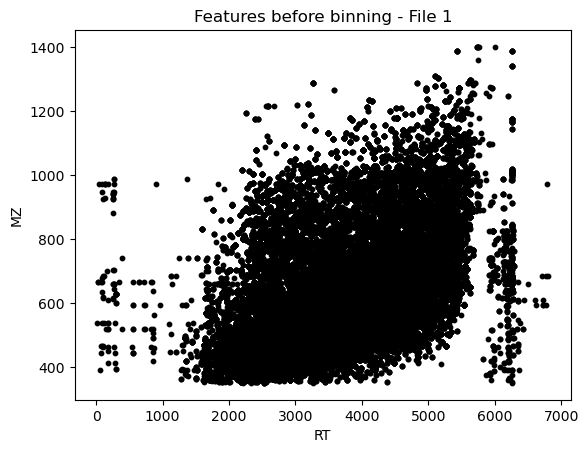

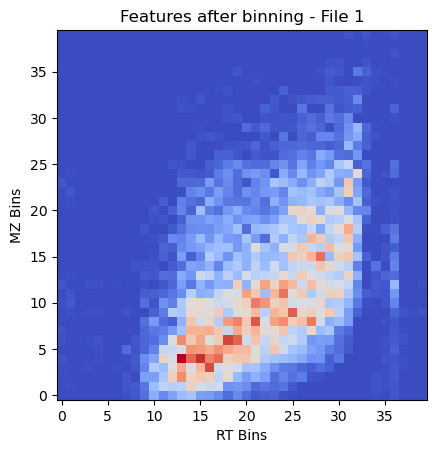

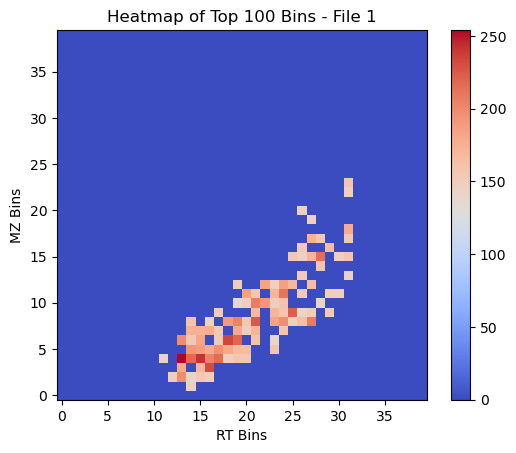

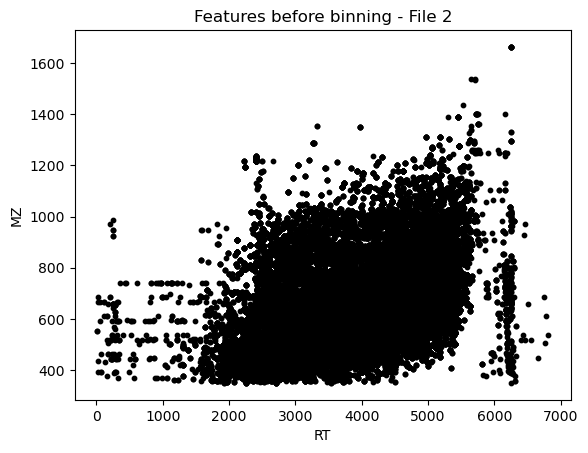

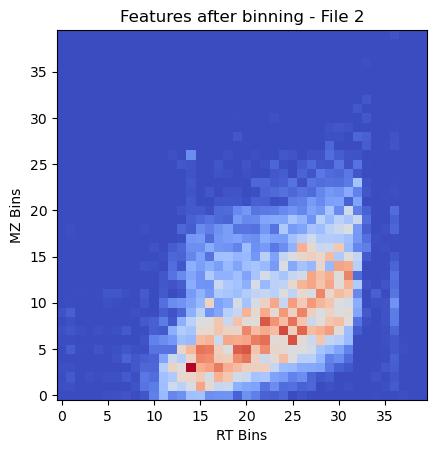

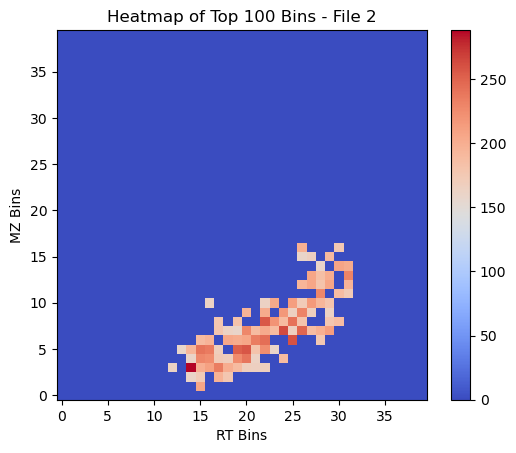

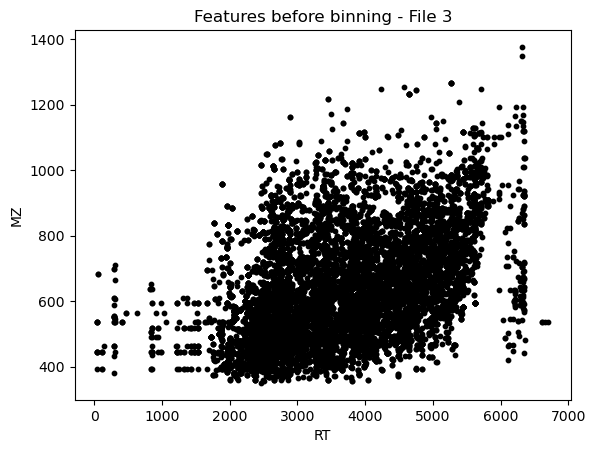

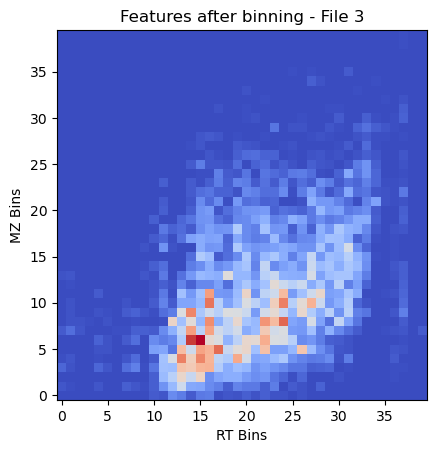

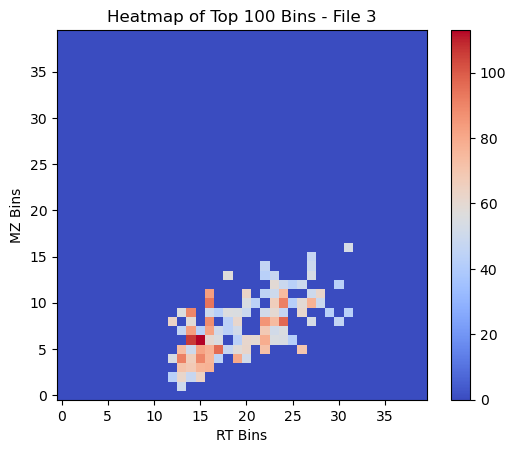

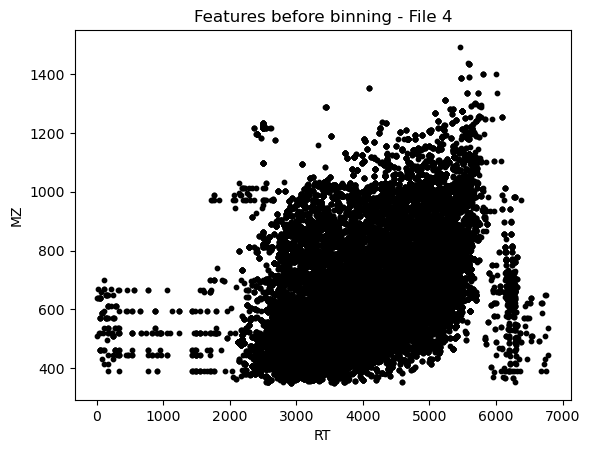

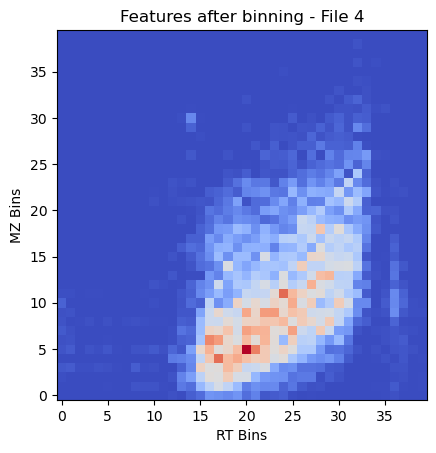

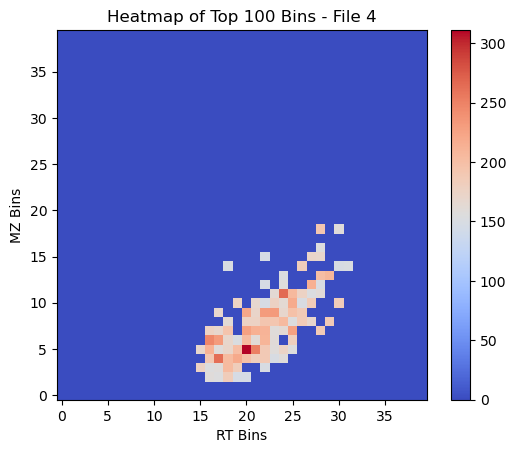

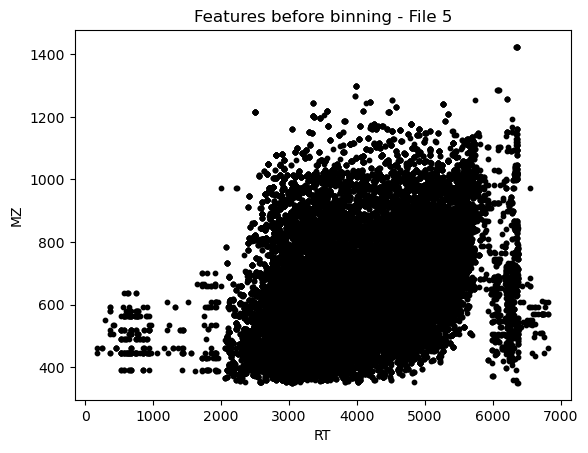

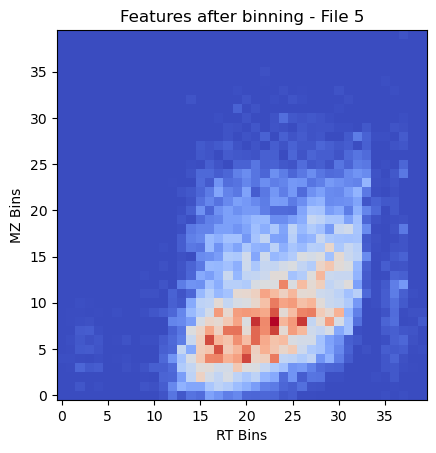

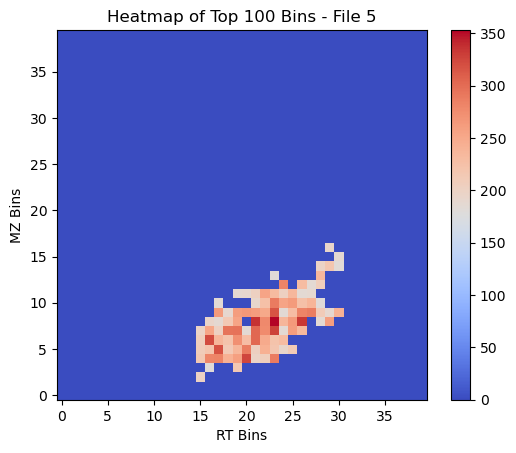

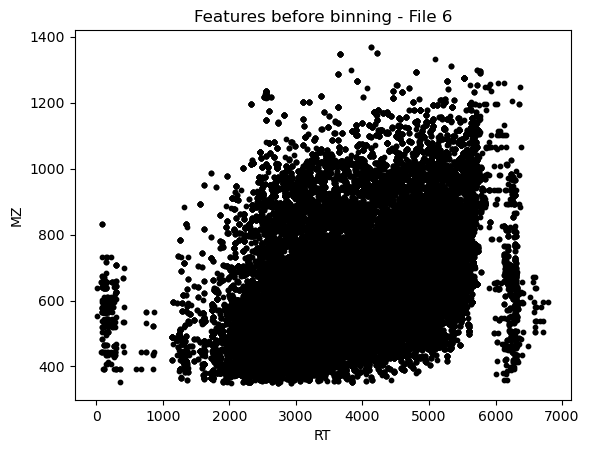

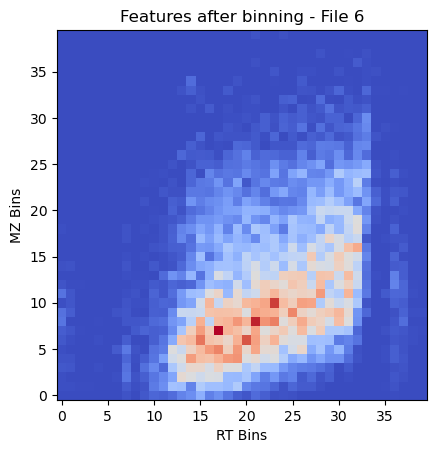

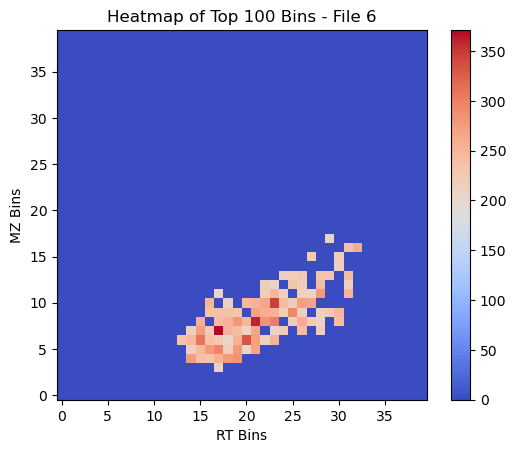

In [3]:
folder_path = "C:/Users/bless/OneDrive/MS_Studies/AML/proteomics/Class_L_L/L_L_FEATURES/"
i = 1
imp_data_pts =[]

for file_path in glob.glob(folder_path + "*.csv"):
    features_H_H = pd.read_csv(file_path)
    RT = features_H_H['RT']
    MZ = features_H_H['mz']
    plt.scatter(RT, MZ, s=10, c='black')
    plt.xlabel('RT')
    plt.ylabel('MZ')
    plt.title(f'Features before binning - File {i}')
    plt.show()

    min_RT = min(RT)
    max_RT = max(RT)
    min_MZ = min(MZ)
    max_MZ = max(MZ)

    RT_nbins = 40
    MZ_nbins = 40
    RT_binsize = (max_RT - min_RT) / RT_nbins
    MZ_binsize = (max_MZ - min_MZ) / MZ_nbins

    rt_ind = np.floor((RT - min_RT) / RT_binsize).astype(int)
    mz_ind = np.floor((MZ - min_MZ) / MZ_binsize).astype(int)

    histogram_2d, _, _ = np.histogram2d(rt_ind, mz_ind, bins=(RT_nbins, MZ_nbins))

    plt.imshow(histogram_2d.T, cmap='coolwarm', origin='lower')  
    plt.xlabel('RT Bins')
    plt.ylabel('MZ Bins')
    plt.title(f'Features after binning - File {i}')
    plt.show()
    
    # Find the indices of the top 30 bins based on count
    top_indices = np.argsort(-histogram_2d, axis=None)[:100]

    # Convert the flat indices to 2D indices
    top_indices_2d = np.unravel_index(top_indices, histogram_2d.shape)

    # Create a mask for the top bins
    top_bins_mask = np.zeros_like(histogram_2d, dtype=bool)
    top_bins_mask[top_indices_2d] = True

    # Apply the mask to retain only the top bins in the heatmap
    heatmap_data = np.where(top_bins_mask, histogram_2d, 0)

    plt.imshow(heatmap_data.T, cmap='coolwarm', origin='lower')
    plt.colorbar()
    plt.title(f'Heatmap of Top 100 Bins - File {i}')
    plt.xlabel('RT Bins')
    plt.ylabel('MZ Bins')
    plt.show()

    top_data_points = []
    for rt_bin, mz_bin in zip(top_indices_2d[0], top_indices_2d[1]):
        mask = (rt_ind == rt_bin) & (mz_ind == mz_bin)
        data_points = np.column_stack((RT[mask], MZ[mask]))
        top_data_points.append(data_points)
    
    imp_data_pts.append(np.concatenate(top_data_points))
    i = i+1

In [35]:
for i in range(len(imp_data_pts)):
    first_column = imp_data_pts[i][:, 0]  # Select the first column
    #imp_data_pts[i][:, 0] = [round(value) for value in first_column]  # Round the values to two decimal places
    print(imp_data_pts[i][:, 0])
    


[2310.2413356  2310.27571474 2310.11185237 ... 3407.45759258 3407.70114683
 3305.04630041]
[2444.59786043 2516.23692632 2516.26810866 ... 2388.41559711 2224.69313549
 2292.24511422]
[2638.79245187 2638.68537034 2638.55906723 ... 4359.12134525 4222.56472384
 4263.64103085]
[3422.89415943 3422.89675449 3422.90182923 ... 3749.90510963 3824.9987766
 3829.38985167]
[4028.71042727 4028.60243464 4028.82185708 ... 4917.54888718 4877.24593812
 4907.53808407]
[3059.736286 3059.632974 3059.842304 ... 3568.992043 3525.167062
 3475.088511]


In [36]:
#rt_avgmv=[]

# for i in range(len(imp_data_pts[0])):
#     print(imp_data_pts[0][i,:])

rt_avgmv = []

for imp_data in imp_data_pts:
    # Get unique RT values
    unique_rt_values = np.unique(imp_data[:, 0])

    # Initialize an array to store the averaged data
    averaged_data = np.zeros((len(unique_rt_values), 2))

    # Calculate average MV values for each unique RT value
    for i, rt in enumerate(unique_rt_values):
        averaged_data[i, 0] = rt
        averaged_data[i, 1] = np.mean(imp_data[imp_data[:, 0] == rt, 1])

    rt_avgmv.append(averaged_data)
    print(averaged_data)

print(len(rt_avgmv[0]))
print(len(imp_data_pts[0]))

[[1899.9791597   460.27966309]
 [1900.0013614   460.27838135]
 [1904.86735963  462.14401245]
 ...
 [5447.03645082  755.90905762]
 [5447.04942293  755.90563965]
 [5447.06054266  755.91253662]]
[[2068.08110548  473.22888184]
 [2068.54767973  473.23565674]
 [2068.55608525  473.2383728 ]
 ...
 [5449.01775492  775.43621826]
 [5450.46293704  825.44970703]
 [5450.50979152  824.96295166]]
[[2057.76299512  571.25035907]
 [2057.79798305  571.26221534]
 [2057.82649878  571.25231879]
 ...
 [5355.63972426  775.4052124 ]
 [5370.56282433  767.86459583]
 [5370.74829281  767.88255032]]
[[2553.75868886  463.92312622]
 [2554.04797116  506.25784302]
 [2554.05377249  506.25473022]
 ...
 [5422.89821956  766.12434055]
 [5422.9659706   766.12788059]
 [5429.23735402  777.92810059]]
[[2666.08139236  510.26437378]
 [2666.11886075  510.26278687]
 [2666.39363688  562.82568359]
 ...
 [5320.04610377  730.91534424]
 [5320.16505549  730.91210938]
 [5320.60670314  616.29119873]]
[[2217.40801    521.3108521]
 [2227.4412

In [37]:
flattened_array=[]
flattened_array.append([arr.flatten() for arr in imp_data_pts])
print(len(flattened_array[0][0]))
print(len(flattened_array[0][1]))
print(len(flattened_array[0][2]))
print(len(flattened_array[0][3]))
print(len(flattened_array[0][4]))
print(len(flattened_array[0][5]))

34086
39440
12246
36558
47418
48834


In [38]:
min_length = min(len(arr) for arr in flattened_array[0])
#print(min_length)
subset_arrays = [arr[:min_length] for arr in flattened_array[0]]

print(subset_arrays)
print(subset_arrays[0].size)
print(subset_arrays[1].size)
print(subset_arrays[2].size)
print(subset_arrays[3].size)
print(subset_arrays[4].size)
print(subset_arrays[5].size)



[array([2310.2413356 ,  462.24624634, 2310.27571474, ...,  453.2401123 ,
       2244.42880717,  451.25430298]), array([2444.59786043,  449.99850464, 2516.23692632, ...,  610.30059814,
       5100.07313741,  581.33258057]), array([2638.79245187,  507.23400879, 2638.68537034, ...,  615.86590576,
       4263.64103085,  609.29949951]), array([3422.89415943,  517.25445557, 3422.89675449, ...,  622.33935547,
       4340.61499305,  616.97039352]), array([4028.71042727,  565.79223633, 4028.60243464, ...,  565.64294434,
       3875.25358381,  578.81054688]), array([3059.736286 ,  544.6087036, 3059.632974 , ...,  620.3832397,
       4718.943413 ,  622.3148193])]
12246
12246
12246
12246
12246
12246


In [39]:
sub_ar=pd.DataFrame(subset_arrays)
sub_ar.to_csv('L_Loutput1.csv', index=False)

In [40]:
sub_ar_h=pd.read_csv("C:/Users/bless/OneDrive/MS_Studies/AML/proteomics/1.csv")
sub_ar_l=pd.read_csv("C:/Users/bless/OneDrive/MS_Studies/AML/proteomics/L_Loutput1.csv")
sub_ar_l['class']=0
sub_ar_l.head(20)

,0,1,2,3,4,5,6,7,8,9,...,12237,12238,12239,12240,12241,12242,12243,12244,12245,class
0,2310.241336,462.246246,2310.275715,462.247528,2310.111852,462.244934,2331.014549,477.257629,2330.508515,457.757904,...,430.229797,2289.406357,445.720886,2372.702757,444.567474,2251.021532,453.240112,2244.428807,451.254303,0
1,2444.597860,449.998505,2516.236926,475.751678,2516.268109,475.753052,2430.027010,462.246246,2430.037246,462.247528,...,579.966370,5042.355007,583.281677,5100.256501,580.856018,5085.716372,610.300598,5100.073137,581.332581,0
2,2638.792452,507.234009,2638.685370,507.232452,2638.559067,507.230896,2580.479357,515.757446,2580.384808,515.759094,...,626.765808,4330.017901,630.890137,4359.121345,630.307517,4222.564724,615.865906,4263.641031,609.299500,0
3,3422.894159,517.254456,3422.896754,517.256042,3422.901829,517.757324,3413.788574,510.246094,3413.863487,510.247681,...,607.837952,4250.585063,628.834290,4347.839678,614.839417,4249.474030,622.339355,4340.614993,616.970394,0
4,4028.710427,565.792236,4028.602435,565.790283,4028.821857,565.794128,4098.710753,567.655884,4119.863261,567.318420,...,578.814636,3975.689105,565.637146,3878.985819,573.803467,3975.586136,565.642944,3875.253584,578.810547,0
5,3059.736286,544.608704,3059.632974,544.606934,3059.842304,544.610535,3059.981881,544.612305,2895.307487,543.325440,...,624.341065,4672.090341,617.843384,4727.540364,609.632507,4716.461312,620.383240,4718.943413,622.314819,0


In [41]:
sub_ar_h=sub_ar_h.iloc[:, :12247]
sub_ar_h['class']=1
sub_ar_h = sub_ar_h.drop("Unnamed: 0", axis=1)
sub_ar_h

,0,1,2,3,4,5,6,7,8,9,...,12237,12238,12239,12240,12241,12242,12243,12244,12245,class
0,3768.215901,584.854065,3768.205167,584.851990,3783.715845,567.654785,3783.830196,567.656738,3787.563605,558.326965,...,588.305127,4424.223611,594.955933,4398.187511,590.343689,4283.559876,601.830994,4316.270735,608.330688,1
1,2797.307919,442.953674,2797.259292,442.954834,2733.689379,449.747192,2797.177762,442.956024,2733.659331,449.748413,...,558.283508,3820.718520,577.265259,3891.882512,577.818848,3868.193308,580.304749,3785.522061,567.812927,1
2,3337.142956,510.246094,3337.398619,510.244507,3336.791641,510.247681,3337.444891,510.242950,3327.188272,517.256042,...,601.294006,4496.664894,608.848938,4541.772104,599.651672,4461.967576,607.676880,4565.202366,600.362549,1
3,3452.686071,510.246094,3453.036993,510.244507,3452.231348,510.247681,3453.323141,510.242950,3494.949350,517.254456,...,629.849121,4133.766005,634.833374,4116.836262,633.851135,4098.593878,638.872009,4104.290957,639.864929,1
4,3935.494383,638.852234,3935.503446,638.849792,3949.110655,638.852234,3935.493997,638.854736,3949.158326,638.854736,...,764.420959,5126.976047,774.461365,5232.850052,764.891968,5159.438800,777.895142,5137.436475,780.912292,1
5,3311.814266,571.822021,3311.783381,571.820068,3311.840220,571.824036,3311.752108,571.818115,3383.196984,575.848877,...,568.827393,4171.685555,577.355225,4163.593596,564.783813,4226.568892,577.282532,4238.956042,565.313721,1


In [42]:
L_X = sub_ar_l.drop("class", axis=1)
L_Y = sub_ar_l[["class"]].copy()

H_X = sub_ar_h.drop("class", axis=1)
H_Y = sub_ar_h[["class"]].copy()

In [97]:
# sub_ar_h
# sub_array=pd.concat([sub_ar_h,sub_ar_l],axis=0)
# sub_array

In [98]:
# X = sub_array.drop("class", axis=1)
# Y = sub_array[["class"]].copy()


# print(X)
# print(Y)

In [101]:
# oversampler = RandomOverSampler(sampling_strategy={0: 100, 1: 100})  # Set the desired number of samples for each class

# # Perform the oversampling
# oversampled_data, oversampled_labels = oversampler.fit_resample(X,Y)
# print(oversampled_data.head(20))

# noise_factor = 0.05  # Adjust this value as per your requirement
# noisy_oversampled_data = oversampled_data + np.random.normal(0, noise_factor, size=oversampled_data.shape)

# # The noisy_oversampled_data now contains the oversampled data with slight variations

# # Print the oversampled data
# oversampled_data=noisy_oversampled_data
# print(oversampled_data.head(20))
# print(oversampled_labels.head(20))
# # Define the custom sampling strategy function
# def custom_sampling_strategy(y):
#     class_counts = np.bincount(y)
#     minority_class = np.argmin(class_counts)
#     majority_class = np.argmax(class_counts)
#     desired_samples = class_counts[majority_class]  # Set desired samples equal to the majority class count

#     # Create a dictionary for sampling strategy
#     sampling_strategy = {}
#     for class_label, count in enumerate(class_counts):
#         if class_label == minority_class:
#             sampling_strategy[class_label] = desired_samples
#         else:
#             sampling_strategy[class_label] = desired_samples - (class_counts[majority_class] - count)

#     return sampling_strategy

# # Create the RandomOverSampler with the custom sampling strategy
# oversampler = RandomOverSampler(sampling_strategy=custom_sampling_strategy)

# # Resample the data
# X_resampled, y_resampled = oversampler.fit_resample(X, Y)
# X_resampled
# #print(y_resampled)


# for i in range(len(sub_array['class'])):
#     print(i)
#     first_column = abs(sub_array['class'][i])  # Select the first column
#     sub_array['class'][i] = round(sub_array['class'][i])  # Round the values to two decimal places
#     print(sub_array['class'][i])

In [102]:
# from imblearn.over_sampling import RandomOverSampler
# import numpy as np

# # Specify the desired number of samples for the class you want to augment
# desired_samples = 100

# # Replace the desired class label
# desired_class_label = 0

# # Find the indices of the samples belonging to the desired class
# class_index = np.where(L_Y == desired_class_label)[0]


# # Extract the samples and labels for the class you want to augment
# class_data = L_X
# class_labels = L_Y

# # Create the random oversampler for the specific class
# oversampler = RandomOverSampler(sampling_strategy={0: desired_samples})

# # Perform the oversampling on the specific class
# oversampled_class_data, oversampled_class_labels = oversampler.fit_resample(class_data, class_labels)

# # Generate noise for augmentation
# noise_factor = 0.05  # Adjust this value as per your requirement
# noise = np.random.normal(0, noise_factor, size=oversampled_class_data.shape)

# # Add noise to the oversampled data
# noisy_oversampled_class_data = oversampled_class_data + noise

# # The noisy_oversampled_class_data now contains the augmented data for the specific class with slight variations

# # Print the augmented data
# print(noisy_oversampled_class_data)
# print(oversampled_class_labels)


In [43]:
# Assuming you have your DataFrame 'df' with shape (6, 28992)
# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit the scaler on the original data
scaler.fit(sub_ar_l)

# Define the desired number of augmented rows
desired_rows = 100

# Generate augmented data
augmented_data = scaler.inverse_transform(
    np.random.randn(desired_rows - len(sub_ar_l), sub_ar_l.shape[1]))

# Convert the augmented data to a DataFrame
augmented_X = pd.DataFrame(augmented_data, columns=sub_ar_l.columns)

# Concatenate the augmented data with the original data
augmented_X = pd.concat([sub_ar_l, augmented_X], ignore_index=True)

augmented_X['class']=0

augmented_X

# Now, 'augmented_df' contains the augmented data with 200 rows, where values are in the normal range of each column


,0,1,2,3,4,5,6,7,8,9,...,12237,12238,12239,12240,12241,12242,12243,12244,12245,class
0,2310.241336,462.246246,2310.275715,462.247528,2310.111852,462.244934,2331.014549,477.257629,2330.508515,457.757904,...,430.229797,2289.406357,445.720886,2372.702757,444.567474,2251.021532,453.240112,2244.428807,451.254303,0
1,2444.597860,449.998505,2516.236926,475.751678,2516.268109,475.753052,2430.027010,462.246246,2430.037246,462.247528,...,579.966370,5042.355007,583.281677,5100.256501,580.856018,5085.716372,610.300598,5100.073137,581.332581,0
2,2638.792452,507.234009,2638.685370,507.232452,2638.559067,507.230896,2580.479357,515.757446,2580.384808,515.759094,...,626.765808,4330.017901,630.890137,4359.121345,630.307517,4222.564724,615.865906,4263.641031,609.299500,0
3,3422.894159,517.254456,3422.896754,517.256042,3422.901829,517.757324,3413.788574,510.246094,3413.863487,510.247681,...,607.837952,4250.585063,628.834290,4347.839678,614.839417,4249.474030,622.339355,4340.614993,616.970394,0
4,4028.710427,565.792236,4028.602435,565.790283,4028.821857,565.794128,4098.710753,567.655884,4119.863261,567.318420,...,578.814636,3975.689105,565.637146,3878.985819,573.803467,3975.586136,565.642944,3875.253584,578.810547,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2228.959480,552.243720,3338.617480,478.384980,2945.006691,505.950358,1424.577491,455.544732,3311.833643,501.346498,...,530.337896,2332.718614,652.391346,4398.732713,543.655688,4159.601531,589.659832,4340.176225,758.305870,0
96,3324.307052,491.837562,2642.108878,579.317672,3947.587546,517.457873,2911.648454,515.225746,2888.315608,451.319272,...,561.136966,3640.319859,550.816392,4840.286649,514.796432,4465.214309,567.332403,2989.912474,585.056069,0
97,2943.583851,503.246986,2866.981798,503.745174,2349.710425,504.788685,3161.767035,531.027622,2944.844270,548.031594,...,490.753375,3360.238686,552.433630,4701.972124,600.242400,3727.993023,476.135993,3706.420481,541.388813,0
98,3160.619600,484.089619,2813.376984,503.893832,3666.240093,501.021132,2321.667808,501.902217,3191.874280,495.067387,...,677.548293,2967.255841,570.598495,2343.512316,432.724950,3571.531307,464.932321,4494.829934,575.184708,0


In [ ]:

# sub_array

In [44]:
scaler = StandardScaler()

# Fit the scaler on the original data
scaler.fit(sub_ar_h)

# Define the desired number of augmented rows
desired_rows = 100

# Generate augmented data
augmented_data = scaler.inverse_transform(
    np.random.randn(desired_rows - len(sub_ar_h), sub_ar_h.shape[1]))

# Convert the augmented data to a DataFrame
augmented_H = pd.DataFrame(augmented_data, columns=sub_ar_h.columns)

# Concatenate the augmented data with the original data
augmented_H = pd.concat([sub_ar_h, augmented_H], ignore_index=True)

augmented_H['class']=1

augmented_H

,0,1,2,3,4,5,6,7,8,9,...,12237,12238,12239,12240,12241,12242,12243,12244,12245,class
0,3768.215901,584.854065,3768.205167,584.851990,3783.715845,567.654785,3783.830196,567.656738,3787.563605,558.326965,...,588.305127,4424.223611,594.955933,4398.187511,590.343689,4283.559876,601.830994,4316.270735,608.330688,1
1,2797.307919,442.953674,2797.259292,442.954834,2733.689379,449.747192,2797.177762,442.956024,2733.659331,449.748413,...,558.283508,3820.718520,577.265259,3891.882512,577.818848,3868.193308,580.304749,3785.522061,567.812927,1
2,3337.142956,510.246094,3337.398619,510.244507,3336.791641,510.247681,3337.444891,510.242950,3327.188272,517.256042,...,601.294006,4496.664894,608.848938,4541.772104,599.651672,4461.967576,607.676880,4565.202366,600.362549,1
3,3452.686071,510.246094,3453.036993,510.244507,3452.231348,510.247681,3453.323141,510.242950,3494.949350,517.254456,...,629.849121,4133.766005,634.833374,4116.836262,633.851135,4098.593878,638.872009,4104.290957,639.864929,1
4,3935.494383,638.852234,3935.503446,638.849792,3949.110655,638.852234,3935.493997,638.854736,3949.158326,638.854736,...,764.420959,5126.976047,774.461365,5232.850052,764.891968,5159.438800,777.895142,5137.436475,780.912292,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3374.095020,685.539862,2859.035102,528.898891,3424.389339,626.431695,3326.954881,539.050186,3450.971787,537.859686,...,627.740367,4719.407020,671.980847,4453.141837,524.359553,4441.454082,669.192839,4029.269546,647.271913,1
96,2749.839848,564.460130,3225.018065,476.205173,3776.253791,645.840667,3567.296893,532.356112,3443.350247,577.713804,...,540.173316,5143.435258,679.668781,4986.560350,616.013341,4770.543386,608.939718,3795.042392,723.913559,1
97,3872.415889,491.794991,4235.598459,574.083811,3359.970461,553.161624,3514.334213,552.592783,3960.130497,588.277402,...,593.919448,4735.420433,482.872155,4244.058668,574.463374,4285.108831,618.570110,4747.612604,659.339678,1
98,4172.160603,530.840571,3131.861600,505.106910,3596.003025,549.897977,3313.688573,688.068126,4244.557699,596.896495,...,649.635756,4171.712378,614.589834,4361.210542,594.089949,4821.553514,616.683014,4844.447994,661.508143,1


In [45]:
sub_array=pd.concat([augmented_X,augmented_H],axis=0)
sub_array
X = sub_array.drop("class", axis=1)
Y = sub_array[["class"]].copy()


print(X)
print(Y)

              0           1            2           3            4           5  \
0   2310.241336  462.246246  2310.275715  462.247528  2310.111852  462.244934   
1   2444.597860  449.998505  2516.236926  475.751678  2516.268109  475.753052   
2   2638.792452  507.234009  2638.685370  507.232452  2638.559067  507.230896   
3   3422.894159  517.254456  3422.896754  517.256042  3422.901829  517.757324   
4   4028.710427  565.792236  4028.602435  565.790283  4028.821857  565.794128   
..          ...         ...          ...         ...          ...         ...   
95  3374.095020  685.539862  2859.035102  528.898891  3424.389339  626.431695   
96  2749.839848  564.460130  3225.018065  476.205173  3776.253791  645.840667   
97  3872.415889  491.794991  4235.598459  574.083811  3359.970461  553.161624   
98  4172.160603  530.840571  3131.861600  505.106910  3596.003025  549.897977   
99  4078.458915  620.373442  2927.837864  437.159388  3201.000203  455.535420   

              6           7

In [46]:
scaler=StandardScaler()
X_array=X.values
scaleX=scaler.fit_transform(X_array)
Scale_X=pd.DataFrame(scaleX,columns=X.columns)
    

In [47]:
Scale_X

,0,1,2,3,4,5,6,7,8,9,...,12236,12237,12238,12239,12240,12241,12242,12243,12244,12245
0,-1.474931,-1.244440,-1.718819,-1.231081,-1.753748,-1.355143,-1.677560,-1.071000,-1.486332,-1.279301,...,-2.636029,-2.260203,-2.592908,-2.191259,-2.593139,-2.267571,-2.912791,-2.240616,-2.543037,-2.198314
1,-1.245416,-1.468689,-1.327630,-0.960368,-1.361228,-1.069142,-1.486163,-1.374619,-1.313397,-1.198742,...,1.192980,-0.229504,1.164264,-0.261885,1.222462,-0.189946,1.225791,-0.005487,1.246204,-0.345492
2,-0.913682,-0.420740,-1.095060,-0.329284,-1.128387,-0.402678,-1.195330,-0.292306,-1.052162,-0.238565,...,0.140499,0.405181,0.192080,0.405852,0.185681,0.563908,-0.034388,0.073713,0.136317,0.052866
3,0.425765,-0.237272,0.394418,-0.128344,0.364995,-0.179807,0.415507,-0.403778,0.396037,-0.337458,...,0.186107,0.148485,0.083671,0.377018,0.169899,0.328108,0.004899,0.165837,0.238456,0.162129
4,1.460654,0.651426,1.544855,0.844605,1.518662,0.837252,1.739503,0.757386,1.622737,0.686582,...,-0.369827,-0.245124,-0.291501,-0.509361,-0.485986,-0.297457,-0.394971,-0.641011,-0.379046,-0.381416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.342403,2.843934,-0.676542,0.105056,0.367828,2.121100,0.247652,0.178810,0.460514,0.157994,...,0.392413,0.418397,0.723511,0.982175,0.317207,-1.051196,0.285185,0.832609,-0.174678,0.593741
196,-0.723985,0.627036,0.018581,-0.951277,1.037775,2.532036,0.712248,0.043417,0.447271,0.873110,...,-0.483603,-0.769170,1.302216,1.090003,1.063411,0.346003,0.765647,-0.024854,-0.485481,1.685417
197,1.193663,-0.703420,1.938009,1.010863,0.245175,0.569790,0.609868,0.452722,1.345196,1.062657,...,-0.055222,-0.040275,0.745365,-1.670190,0.024718,-0.287397,0.056925,0.112197,0.778513,0.765633
198,1.705704,0.011482,-0.158354,-0.371894,0.694579,0.500691,0.222008,3.192832,1.839399,1.217312,...,0.005058,0.715339,-0.023972,0.177231,0.188603,0.011796,0.840120,0.085341,0.907007,0.796520


In [48]:

Y=LabelEncoder().fit_transform(Y)
X_train,X_test,Y_train,Y_test=train_test_split(Scale_X,Y,test_size=1/3,stratify=Y,random_state=0)

print(X_train)
    

            0         1         2         3         4         5         6  \
130  0.942377  2.289327  0.429366  0.178768 -0.826862 -0.458503 -0.080703   
118  1.387128  1.251944  0.500292 -0.758366  1.368658  1.727348 -0.092849   
178  0.710864 -0.432035  0.529451  0.382706  0.334268  0.148753  0.291213   
105  0.236012  0.761828  0.183377  0.965482  0.153535  0.964920  0.218264   
172  0.759963 -0.052675  0.402088  0.808829 -1.003874  1.524946 -0.224743   
..        ...       ...       ...       ...       ...       ...       ...   
27  -1.123077 -1.340210 -0.652970  0.010048 -1.660900  0.371345 -2.672060   
55   0.743721  0.504484 -1.165255 -0.930253 -0.573941  0.289175  1.073719   
129 -0.565775  1.535256  0.313630  1.075523  0.459036  0.206166  1.221870   
45  -0.028230  1.051673 -1.169997 -0.184640  1.082084  1.067373 -0.833357   
156  0.462667 -2.461612 -0.401727  1.587289  0.815170 -1.459668  0.086548   

            7         8         9  ...     12236     12237     12238  \
130

C:\Users\bless\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [27]:
print(X_test)

            0         1         2         3         4         5         6  \
132  0.432488 -1.843140  1.325989 -0.571735  0.352865 -0.067695  0.746205   
70  -1.048049  0.632817 -1.946782 -0.511073 -0.382153 -1.790413  0.068689   
189  0.454120 -0.157430  0.454144  0.352083  0.553348 -0.204632  0.404582   
14  -2.158409 -0.419794 -0.605246 -1.426757  0.913297 -0.025033  0.767169   
143  0.701040 -0.425039 -0.752970 -0.596801  0.669995  2.669639  0.875354   
..        ...       ...       ...       ...       ...       ...       ...   
95  -1.670037 -1.482974 -0.271823  0.223482  0.064237  0.541706 -1.163737   
32  -1.025943  0.302196 -0.192993 -0.081826 -0.802377  0.303443 -0.346268   
158 -0.134908  1.017511 -0.560416 -1.063269  1.715256  0.293463  0.120279   
100  1.038495  0.964505  1.020901  1.052497  1.123523  0.831151  1.036396   
77  -1.580965 -0.325656 -1.197376 -0.367579 -0.163738 -0.489738  0.206631   

            7         8         9  ...     12236     12237     12238  \
132

In [29]:
print(len(Y_train))
#Y_train

133


array([1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1], dtype=int64)

In [49]:
#ADABOOST
n_estimators_list = [5,10,50,100]
for n_estimators in n_estimators_list:
    # Initialize the AdaBoost Classifier
    ada_classifier = AdaBoostClassifier(n_estimators=n_estimators, random_state=1) #THIS ONE TAKES A LOOOOOOT OF TIME

    # Fit the classifier on the training data
    ada_classifier.fit(X_train, Y_train)

    # Predict probabilities on the test data
    probs = ada_classifier.predict_proba(X_test)

    # Extract the probabilities of the positive class
    positive_class_probs = probs[:, 1]

    # Calculate the AUC score
    auc_score = roc_auc_score(Y_test, positive_class_probs)

    print('Number of estimators:', n_estimators)
    print('AUC score:', auc_score)
    print('---------------------------------------------------------')
        

Number of estimators: 5
AUC score: 0.9946524064171123
---------------------------------------------------------
Number of estimators: 10
AUC score: 0.9982174688057041
---------------------------------------------------------
Number of estimators: 50
AUC score: 1.0
---------------------------------------------------------
Number of estimators: 100
AUC score: 1.0
---------------------------------------------------------


In [50]:
adaboost = AdaBoostClassifier(n_estimators=5, random_state=14)
adaboost.fit(X_train, Y_train)
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
probabilities_train = cross_val_predict(adaboost, X_train, Y_train, cv=kfold, method='predict_proba')

In [51]:
Y_pred_train = [0 if p[0] > 0.5 else 1 for p in probabilities_train]
print(Y_pred_train)
print(Y_train)

[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1]
[1 1 1 1 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 1 1 1 1 1 0 1 0 1 0 0 0 1 1 0 0 0 0
 0 1 0 0 0 1 0 0 1 1 1 1 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 0 1 0 1 0 0 1 1 1 0
 0 0 0 1 0 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0
 1 1 0 0 1 0 0 1 1 0 0 0 1 1 0 1 1 0 0 1 0 1]


In [57]:
cm = confusion_matrix(Y_train, Y_pred_train)
cm

array([[64,  2],
       [ 3, 64]], dtype=int64)

In [56]:
# Calculate scores
accuracy = accuracy_score(Y_train, Y_pred_train)
precision = precision_score(Y_train, Y_pred_train)
#recall = recall_score(Y_train, Y_pred_train)
f1 = f1_score(Y_train, Y_pred_train)

# Print the scores
print("For training data:")
print("Accuracy : %.3f" % accuracy)
print("Precision : %.3f" % precision)
#print("Recall : %.3f" % recall)
print("F1-score : %.3f" % f1)
# Calculate sensitivity (also known as recall or true positive rate)
sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])

# Calculate specificity (also known as true negative rate)
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

print("Sensitivity (Recall):", sensitivity)
print("Specificity (True Negative Rate):", specificity)


For training data:
Accuracy : 0.962
Precision : 0.970
F1-score : 0.962
Sensitivity (Recall): 0.9552238805970149
Specificity (True Negative Rate): 0.9696969696969697


In [59]:
ada=adaboost.fit(X_train, Y_train)
test_pro=ada.predict_proba(X_test)

In [60]:
test_pro
Y_pred_test = [0 if p[0] > 0.5 else 1 for p in test_pro]
print(Y_pred_test)
print(">>>>>>>>>>>>>>>>>>>>>>>>>")
print(Y_test)

[1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0]
>>>>>>>>>>>>>>>>>>>>>>>>>
[1 0 1 0 1 1 1 1 1 1 0 1 1 1 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 1 1 0 0 1 0 0 0
 1 1 1 1 0 1 1 0 1 0 0 0 1 1 0 0 0 1 0 0 1 0 0 1 0 0 0 1 1 0]


In [62]:
cm_test = confusion_matrix(Y_test, Y_pred_test)
cm_test

array([[32,  2],
       [ 2, 31]], dtype=int64)

In [63]:
# Calculate scores
accuracy = accuracy_score(Y_test, Y_pred_test)
precision = precision_score(Y_test, Y_pred_test)
#recall = recall_score(Y_train, Y_pred_train)
f1 = f1_score(Y_test, Y_pred_test)

# Print the scores
print("For training data:")
print("Accuracy : %.3f" % accuracy)
print("Precision : %.3f" % precision)
#print("Recall : %.3f" % recall)
print("F1-score : %.3f" % f1)
# Calculate sensitivity (also known as recall or true positive rate)
sensitivity = cm_test[1, 1] / (cm_test[1, 1] + cm_test[1, 0])

# Calculate specificity (also known as true negative rate)
specificity = cm_test[0, 0] / (cm_test[0, 0] + cm_test[0, 1])

print("Sensitivity (Recall):", sensitivity)
print("Specificity (True Negative Rate):", specificity)

For training data:
Accuracy : 0.940
Precision : 0.939
F1-score : 0.939
Sensitivity (Recall): 0.9393939393939394
Specificity (True Negative Rate): 0.9411764705882353


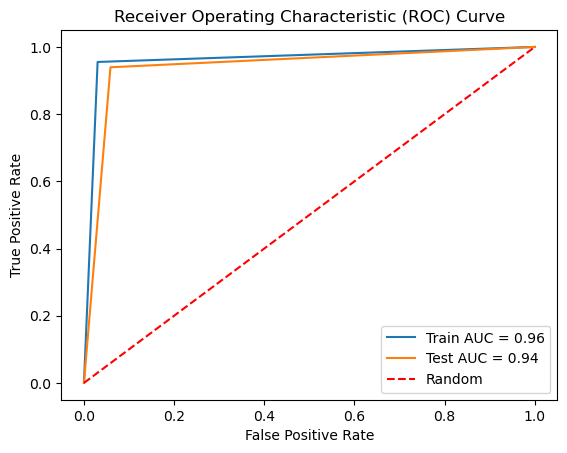

In [64]:
fpr_train, tpr_train, thresholds_train = roc_curve(Y_train, Y_pred_train)
auc_train = roc_auc_score(Y_train, Y_pred_train)

# For test set
fpr_test, tpr_test, thresholds_test = roc_curve(Y_test, Y_pred_test)
auc_test = roc_auc_score(Y_test, Y_pred_test)

# Plot the ROC curves
plt.plot(fpr_train, tpr_train, label=f'Train AUC = {auc_train:.2f}')
plt.plot(fpr_test, tpr_test, label=f'Test AUC = {auc_test:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [65]:
#XGBOOST
n_estimators_list = [5,10,50,100]

for est in n_estimators_list:
    # Initialize the XGBoost Classifier
    xgb_classifier = xgb.XGBClassifier(n_estimators=est, random_state=1)

    # Fit the classifier on the training data
    xgb_classifier.fit(X_train, Y_train)

    # Predict probabilities on the test data
    X_probs = xgb_classifier.predict_proba(X_test)

    # Extract the probabilities of the positive class
    X_positive_class_probs = X_probs[:, 1]

    # Calculate the AUC score
    X_auc_score = roc_auc_score(Y_test, X_positive_class_probs)

    print('Number of estimators:', est)
    print('AUC score:', X_auc_score)
    print('---------------------------------------------------------')

   

        

Number of estimators: 5
AUC score: 0.9884135472370766
---------------------------------------------------------
Number of estimators: 10
AUC score: 0.9982174688057041
---------------------------------------------------------
Number of estimators: 50
AUC score: 1.0
---------------------------------------------------------
Number of estimators: 100
AUC score: 1.0
---------------------------------------------------------


In [66]:
xgb_classifier = xgb.XGBClassifier(n_estimators=5, random_state=14)
xgb_classifier.fit(X_train, Y_train)
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
X_probabilities_train = cross_val_predict(xgb_classifier, X_train, Y_train, cv=kfold, method='predict_proba')

In [67]:
X_Y_pred_train = [0 if p[0] > 0.5 else 1 for p in X_probabilities_train]
print(X_Y_pred_train)
print(Y_train)

[1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1]
[1 1 1 1 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 1 1 1 1 1 0 1 0 1 0 0 0 1 1 0 0 0 0
 0 1 0 0 0 1 0 0 1 1 1 1 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 0 1 0 1 0 0 1 1 1 0
 0 0 0 1 0 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0
 1 1 0 0 1 0 0 1 1 0 0 0 1 1 0 1 1 0 0 1 0 1]


In [68]:
cm = confusion_matrix(Y_train, X_Y_pred_train)
cm

array([[64,  2],
       [ 4, 63]], dtype=int64)

In [69]:
# Calculate scores
accuracy = accuracy_score(Y_train, X_Y_pred_train)
precision = precision_score(Y_train, X_Y_pred_train)
#recall = recall_score(Y_train, Y_pred_train)
f1 = f1_score(Y_train, X_Y_pred_train)

# Print the scores
print("For training data:")
print("Accuracy : %.3f" % accuracy)
print("Precision : %.3f" % precision)
#print("Recall : %.3f" % recall)
print("F1-score : %.3f" % f1)
# Calculate sensitivity (also known as recall or true positive rate)
sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])

# Calculate specificity (also known as true negative rate)
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

print("Sensitivity (Recall):", sensitivity)
print("Specificity (True Negative Rate):", specificity)

For training data:
Accuracy : 0.955
Precision : 0.969
F1-score : 0.955
Sensitivity (Recall): 0.9402985074626866
Specificity (True Negative Rate): 0.9696969696969697


In [77]:
xgb=xgb_classifier.fit(X_train, Y_train)
X_test_pro=xgb.predict_proba(X_test)

In [78]:
X_test_pro
X_Y_pred_test = [0 if p[0] > 0.5 else 1 for p in X_test_pro]
print(X_Y_pred_test)
print(">>>>>>>>>>>>>>>>>>>>>>>>>")
print(Y_test)

[1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0]
>>>>>>>>>>>>>>>>>>>>>>>>>
[1 0 1 0 1 1 1 1 1 1 0 1 1 1 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 1 1 0 0 1 0 0 0
 1 1 1 1 0 1 1 0 1 0 0 0 1 1 0 0 0 1 0 0 1 0 0 1 0 0 0 1 1 0]


In [79]:
cm_test = confusion_matrix(Y_test, X_Y_pred_test)
cm_test


array([[34,  0],
       [ 4, 29]], dtype=int64)

In [80]:
# Calculate scores
accuracy = accuracy_score(Y_test, X_Y_pred_test)
precision = precision_score(Y_test, X_Y_pred_test)
#recall = recall_score(Y_train, Y_pred_train)
f1 = f1_score(Y_test, X_Y_pred_test)

# Print the scores
print("For training data:")
print("Accuracy : %.3f" % accuracy)
print("Precision : %.3f" % precision)
#print("Recall : %.3f" % recall)
print("F1-score : %.3f" % f1)
# Calculate sensitivity (also known as recall or true positive rate)
sensitivity = cm_test[1, 1] / (cm_test[1, 1] + cm_test[1, 0])

# Calculate specificity (also known as true negative rate)
specificity = cm_test[0, 0] / (cm_test[0, 0] + cm_test[0, 1])

print("Sensitivity (Recall):", sensitivity)
print("Specificity (True Negative Rate):", specificity)

For training data:
Accuracy : 0.940
Precision : 1.000
F1-score : 0.935
Sensitivity (Recall): 0.8787878787878788
Specificity (True Negative Rate): 1.0


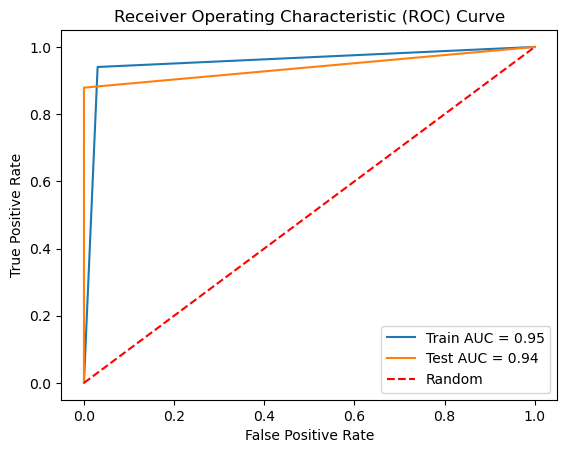

In [81]:
fpr_train, tpr_train, thresholds_train = roc_curve(Y_train, X_Y_pred_train)
auc_train = roc_auc_score(Y_train, X_Y_pred_train)

# For test set
fpr_test, tpr_test, thresholds_test = roc_curve(Y_test, X_Y_pred_test)
auc_test = roc_auc_score(Y_test, X_Y_pred_test)

# Plot the ROC curves
plt.plot(fpr_train, tpr_train, label=f'Train AUC = {auc_train:.2f}')
plt.plot(fpr_test, tpr_test, label=f'Test AUC = {auc_test:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()